# REBEL MODEL

Paper: https://aclanthology.org/2021.findings-emnlp.204.pdf

Git: https://github.com/Babelscape/rebel

## Rebel Models Triplet extraction

In [ ]:
import pandas as pd
from tqdm import tqdm
from transformers import pipeline
import torch
import re

# --- Parsing functions ---

import re

def extract_triplets_mrebel(text):
    # Remove language tokens
    text = re.sub(r">>.*?<<", "", text)
    triplets = []
    # Split by <triplet>
    for triplet_str in text.split("<triplet>"):
        triplet_str = triplet_str.strip()
        if not triplet_str:
            continue
        # Find all type tokens and their positions
        matches = list(re.finditer(r"<[^>]+>", triplet_str))
        if len(matches) < 2:
            continue
        # Subject is before first type token
        subject = triplet_str[:matches[0].start()].strip()
        subject_type = matches[0].group(0).replace("<", "").replace(">", "").capitalize()
        # Object is after second type token
        object_ = triplet_str[matches[1].end():].strip()
        object_type = matches[1].group(0).replace("<", "").replace(">", "").capitalize()
        # TAIL is between the two type tokens
        TAIL = triplet_str[matches[0].end():matches[1].start()].strip()
        # Remove any type tokens from subject/object
        subject = re.sub(r"<[^>]+>", "", subject).strip()
        object_ = re.sub(r"<[^>]+>", "", object_).strip()
        # Split if there are multiple relations/entities (by double/triple spaces or '  ')
        for rel, obj in zip(TAIL.split("  "), object_.split("  ")):
            rel = rel.strip()
            obj = obj.strip()
            if subject and rel and obj:
                triplets.append({
                    'head': subject,
                    'head_type': subject_type,
                    'type': rel,
                    'RELATION': obj,
                    'tail_type': object_type
                })
    return triplets

def extract_triplets_rebel(text):
    # Remove language tokens
    text = re.sub(r">>.*?<<", "", text)
    triplets = []
    # Split by <triplet>
    for triplet_str in text.split("<triplet>"):
        triplet_str = triplet_str.strip()
        if not triplet_str:
            continue
        # Format: subject <subj> TAIL <obj> object
        subj_match = re.search(r"(.*?)<subj>", triplet_str)
        rel_match = re.search(r"<subj>(.*?)<obj>", triplet_str)
        obj_match = re.search(r"<obj>(.*)", triplet_str)
        if subj_match and rel_match and obj_match:
            subject = subj_match.group(1).strip()
            TAIL = rel_match.group(1).strip()
            object_ = obj_match.group(1).strip()
            # Remove any tags accidentally left
            subject = re.sub(r"<[^>]+>", "", subject).strip()
            TAIL = re.sub(r"<[^>]+>", "", TAIL).strip()
            object_ = re.sub(r"<[^>]+>", "", object_).strip()
            if subject and TAIL and object_:
                triplets.append({
                    'head': subject,
                    'head_type': '',
                    'type': TAIL,
                    'RELATION': object_,
                    'tail_type': ''
                })
    return triplets

# --- Device selection ---
device_to_use = 0 if torch.cuda.is_available() else -1
print(f"Using device: {'cuda:' + str(device_to_use) if device_to_use != -1 else 'cpu'}")

# --- Pipelines ---
triplet_extractor_mrebel = pipeline(
    'translation',
    model='Babelscape/mrebel-large',
    tokenizer='Babelscape/mrebel-large',
    device=device_to_use
)
triplet_extractor_rebel = pipeline(
    'text2text-generation',
    model='Babelscape/rebel-large',
    tokenizer='Babelscape/rebel-large',
    device=device_to_use
)

df = pd.read_csv('JuanRana_split.csv')
all_triplets = []

for index, row in tqdm(df.iterrows(), total=len(df), desc="Processing documents"):
    document = row['ID']
    text = row['Text']

    # --- mREBEL ---
    try:
        output = triplet_extractor_mrebel(
            text,
            src_lang="es_XX",
            tgt_lang="es_XX",
            max_length=400,
            return_tensors=True,
            return_text=False
        )[0]["translation_token_ids"]
        decoded = triplet_extractor_mrebel.tokenizer.batch_decode([output], skip_special_tokens=False)[0]
        triplets_mrebel = extract_triplets_mrebel(decoded)
    except Exception as e:
        print(f"Error processing row {index} with mREBEL: {e}")
        triplets_mrebel = []

    # --- REBEL ---
    try:
        output = triplet_extractor_rebel(
            text,
            max_length=400,
            return_tensors=True,
            return_text=False
        )[0]["generated_token_ids"]
        decoded = triplet_extractor_rebel.tokenizer.batch_decode([output], skip_special_tokens=False)[0]
        triplets_rebel = extract_triplets_rebel(decoded)
    except Exception as e:
        print(f"Error processing row {index} with REBEL: {e}")
        triplets_rebel = []

    # --- Append ---
    for i, triplet in enumerate(triplets_mrebel, 1):
        all_triplets.append({
            "DOCUMENT": document,
            "SUBLABEL": i,
            "MODEL": "mrebel",
            "HEAD": triplet.get('head', ''),
            "TAIL": triplet.get('type', ''),
            "RELATION": triplet.get('RELATION', ''),
            "HEAD_TYPE": triplet.get('head_type', ''),
            "TAIL_TYPE": triplet.get('tail_type', '')
        })
    for i, triplet in enumerate(triplets_rebel, 1):
        all_triplets.append({
            "DOCUMENT": document,
            "SUBLABEL": i,
            "MODEL": "rebel",
            "HEAD": triplet.get('head', ''),
            "TAIL": triplet.get('type', ''),
            "RELATION": triplet.get('RELATION', ''),
            "HEAD_TYPE": triplet.get('head_type', ''),
            "TAIL_TYPE": triplet.get('tail_type', '')
        })

result_df = pd.DataFrame(all_triplets)
result_df.to_csv('triplets_output.csv', index=False)
print("Processing complete. Triplets saved to triplets_output.csv")

## NETWORK VISUALIZATION

In [6]:
import pandas as pd
import networkx as nx
from pyvis.network import Network
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path
from collections import Counter

# Set the style for matplotlib
plt.style.use('dark_background')
sns.set_palette("viridis")

# Load the data
df = pd.read_csv('triplets_output.csv')

# Clean up the data
df['TAIL'] = df['TAIL'].str.split('  ').str[0]
df = df.drop_duplicates(subset=['HEAD', 'TAIL', 'RELATION'])

# Create separate dataframes for each model
rebel_df = df[df['MODEL'] == 'rebel']
mrebel_df = df[df['MODEL'] == 'mrebel']

def count_entity_occurrences(dataframe):
    """Count how many times each entity appears as HEAD or RELATION"""
    # Count HEAD occurrences
    head_counts = dataframe['HEAD'].value_counts().to_dict()
    # Count RELATION occurrences
    tail_counts = dataframe['RELATION'].value_counts().to_dict()
    
    # Combine counts
    combined_counts = {}
    for entity, count in head_counts.items():
        combined_counts[entity] = count
    
    for entity, count in tail_counts.items():
        if entity in combined_counts:
            combined_counts[entity] += count
        else:
            combined_counts[entity] = count
            
    return combined_counts

def create_pyvis_network(df, title, filename, physics=True):
    """Create an interactive network visualization using Pyvis"""
    # Create a new network
    net = Network(height="750px", width="100%", bgcolor="#222222", font_color="white")
    net.barnes_hut(spring_length=250, spring_strength=0.001, damping=0.09)
    
    if not physics:
        net.toggle_physics(False)
    
    # Define groups based on entity types
    groups = {
        'Per': 0,
        'Loc': 1,
        'Concept': 2,
        'Org': 3,
        'Eve': 4,
        'Media': 5,
        'Date': 6,
        'Time': 7,
        'Dis': 8,
        'Misc': 9
    }
    
    # Define colors for each group
    colors = ["#ff3333", "#33ff33", "#3333ff", "#ffff33", "#33ffff", "#ff33ff", "#ffaa33", 
              "#dd5555", "#55dd55", "#5555dd"]
    
    # Count entity occurrences for node sizing
    entity_counts = count_entity_occurrences(df)
    max_count = max(entity_counts.values()) if entity_counts else 1
    min_size = 15  # Minimum node size
    max_size = 70  # Maximum node size
    
    # Add nodes to the network (only unique entities)
    entities = set(df['HEAD'].tolist() + df['RELATION'].tolist())
    
    for entity in entities:
        if pd.isna(entity):
            continue
        
        # Determine entity type for group assignment
        head_types = df[df['HEAD'] == entity]['HEAD_TYPE'].dropna().tolist()
        tail_types = df[df['RELATION'] == entity]['TAIL_TYPE'].dropna().tolist()
        
        entity_type = None
        if head_types:
            entity_type = head_types[0]
        elif tail_types:
            entity_type = tail_types[0]
        
        # Calculate node size based on occurrence frequency
        count = entity_counts.get(entity, 1)
        # Use log scale to prevent extremely large nodes
        size = min_size + (max_size - min_size) * (np.log1p(count) / np.log1p(max_count))
        
        # Set tooltip to show count and type information
        tooltip = f"{entity} ({entity_type if entity_type else 'Unknown'}) - Appears {count} times"
        
        # Set node properties based on type
        if entity_type in groups:
            group = groups.get(entity_type, 9)  # Default to Misc (9) if not found
            color = colors[group]
            net.add_node(entity, label=entity, title=tooltip, 
                         color=color, size=size, font={'size': min(16, 10 + size/10)})
        else:
            net.add_node(entity, label=entity, title=tooltip, 
                         size=size, color="#aaaaaa", font={'size': min(14, 8 + size/10)})
    
    # Add edges with relationship types - proper representation of HEAD->TAIL->RELATION
    relation_counts = {}
    for _, row in df.iterrows():
        if pd.isna(row['HEAD']) or pd.isna(row['RELATION']):
            continue
        
        # Count each relationship for edge thickness
        rel_key = (row['HEAD'], row['TAIL'], row['RELATION'])
        if rel_key in relation_counts:
            relation_counts[rel_key] += 1
        else:
            relation_counts[rel_key] = 1
    
    # Add edges with weights based on relationship frequency
    for rel_key, count in relation_counts.items():
        head, TAIL, RELATION = rel_key
        # Scale edge width based on count (logarithmic scaling)
        width = 1 + np.log1p(count)
        net.add_edge(head, RELATION, title=TAIL, 
                    label=TAIL, arrows="to", width=width,
                    physics=True, smooth=True)
    
    # Set network options
    net.set_options("""
    const options = {
        "nodes": {
            "borderWidth": 2,
            "borderWidthSelected": 4,
            "shape": "dot",
            "shadow": true
        },
        "edges": {
            "color": {
                "inherit": "both",
                "opacity": 0.8
            },
            "font": {
                "size": 12,
                "strokeWidth": 4,
                "strokeColor": "#b3adad"
            },
            "smooth": {
                "type": "continuous",
                "forceDirection": "none"
            }
        },
        "physics": {
            "barnesHut": {
                "gravitationalConstant": -50000,
                "centralGravity": 0.3,
                "springLength": 150,
                "springConstant": 0.05,
                "damping": 0.09,
                "avoidOverlap": 0.2
            },
            "maxVelocity": 50,
            "minVelocity": 0.1,
            "solver": "barnesHut",
            "stabilization": {
                "enabled": true,
                "iterations": 1000,
                "updateInterval": 100,
                "onlyDynamicEdges": false,
                "fit": true
            },
            "timestep": 0.5
        },
        "interaction": {
            "hover": true,
            "multiselect": true,
            "navigationButtons": true
        }
    }
    """)
    
    # Add a title to the HTML file
    html_title = f"""
    <h1 style="text-align: center; color: white; font-family: 'Arial', sans-serif; 
            background-color: #333333; padding: 20px; border-radius: 10px; 
            box-shadow: 0px 5px 15px rgba(0, 0, 0, 0.3);">
        {title}
    </h1>
    <p style="text-align: center; color: #cccccc; font-family: 'Arial', sans-serif;">
        Entities: {len(entities)} | Relationships: {len(df)} | Node size = frequency of appearance
    </p>
    """
    
    # Make sure directory exists
    Path("visualizations").mkdir(exist_ok=True)
    
    # Save file
    net.save_graph(f"visualizations/{filename}.html")
    
    # Add the HTML title and legend to the generated file
    with open(f"visualizations/{filename}.html", "r", encoding="utf-8") as f:
        html_content = f.read()
    
    with open(f"visualizations/{filename}.html", "w", encoding="utf-8") as f:
        html_content = html_content.replace("</head>", """
        <style>
        .legend {
            position: absolute;
            bottom: 20px;
            left: 20px;
            background: rgba(34, 34, 34, 0.8);
            border-radius: 10px;
            padding: 15px;
            color: white;
            font-family: Arial, sans-serif;
            z-index: 1000;
            box-shadow: 0px 5px 15px rgba(0, 0, 0, 0.3);
        }
        .legend-item {
            display: flex;
            align-items: center;
            margin-bottom: 5px;
        }
        .legend-color {
            width: 15px;
            height: 15px;
            border-radius: 50%;
            margin-right: 10px;
        }
        </style>
        </head>""")
        
        html_content = html_content.replace("<body>", f"<body>\n{html_title}")
        
        # Add a legend to the visualization
        legend = """
        <div class="legend">
            <h3 style="margin-top: 0">Entity Types</h3>
            <div class="legend-item"><div class="legend-color" style="background: #ff3333"></div>Person</div>
            <div class="legend-item"><div class="legend-color" style="background: #33ff33"></div>Location</div>
            <div class="legend-item"><div class="legend-color" style="background: #3333ff"></div>Concept</div>
            <div class="legend-item"><div class="legend-color" style="background: #ffff33"></div>Organization</div>
            <div class="legend-item"><div class="legend-color" style="background: #33ffff"></div>Event</div>
            <div class="legend-item"><div class="legend-color" style="background: #ff33ff"></div>Media</div>
            <div class="legend-item"><div class="legend-color" style="background: #ffaa33"></div>Date</div>
            <h3>Visual Guide</h3>
            <div>• Larger nodes = More frequent entities</div>
            <div>• Thicker lines = More common relationships</div>
            <div>• Lines represent relationships between entities</div>
        </div>
        """
        
        html_content = html_content.replace("<body>", f"<body>\n{legend}")
        f.write(html_content)
    
    print(f"Interactive visualization saved to 'visualizations/{filename}.html'")

def create_network_summary_image(df, title, filename):
    """Create a static network visualization using NetworkX and Matplotlib"""
    G = nx.DiGraph()
    
    # Count entity occurrences for node sizing
    entity_counts = count_entity_occurrences(df)
    
    # Add nodes
    entities = set(df['HEAD'].tolist() + df['RELATION'].tolist())
    for entity in entities:
        if pd.isna(entity):
            continue
        G.add_node(entity, count=entity_counts.get(entity, 1))
    
    # Create an edge counter
    edge_counter = {}
    
    # Add edges
    for _, row in df.iterrows():
        if pd.isna(row['HEAD']) or pd.isna(row['RELATION']):
            continue
        
        # Count edges
        edge_key = (row['HEAD'], row['RELATION'])
        if edge_key in edge_counter:
            edge_counter[edge_key] += 1
        else:
            edge_counter[edge_key] = 1
            G.add_edge(row['HEAD'], row['RELATION'], TAIL=row['TAIL'])
    
    # Update edge weights
    for (head, RELATION), weight in edge_counter.items():
        if G.has_edge(head, RELATION):
            G[head][RELATION]['weight'] = weight
    
    # Get the top entities by frequency and connectivity
    top_entities = sorted(
        [(node, entity_counts.get(node, 0) * G.degree(node)) for node in G.nodes()], 
        key=lambda x: x[1], 
        reverse=True
    )[:25]
    
    # Create a subgraph of the important entities
    top_names = [n[0] for n in top_entities]
    subG = G.subgraph(top_names)
    
    # Create the figure
    plt.figure(figsize=(18, 14))
    plt.title(f"{title}\n(Top 25 entities by importance)", fontsize=22, fontweight='bold', pad=20, color='white')
    
    # Use a spring layout for node positioning
    pos = nx.spring_layout(subG, k=0.4, iterations=100, seed=42)
    
    # Calculate node sizes based on frequency
    max_count = max(entity_counts.values()) if entity_counts else 1
    node_sizes = []
    for node in subG.nodes():
        count = entity_counts.get(node, 1)
        # Size based on log scale of count
        size = 1000 * (np.log1p(count) / np.log1p(max_count))
        # Also factor in connectivity
        degree_factor = 0.5 + 0.5 * (subG.degree(node) / max([d for _, d in subG.degree()]) if subG.degree() else 1)
        size = size * degree_factor
        # Ensure minimum visibility
        node_sizes.append(max(size, 300))
    
    # Get node colors based on type
    node_colors = []
    color_map = {
        'Per': '#ff3333',
        'Loc': '#33ff33',
        'Concept': '#3333ff',
        'Org': '#ffff33',
        'Eve': '#33ffff',
        'Media': '#ff33ff',
        'Date': '#ffaa33'
    }
    
    for node in subG.nodes():
        # Try to find the node type
        head_types = df[df['HEAD'] == node]['HEAD_TYPE'].dropna().tolist()
        tail_types = df[df['RELATION'] == node]['TAIL_TYPE'].dropna().tolist()
        
        node_type = None
        if head_types:
            node_type = head_types[0]
        elif tail_types:
            node_type = tail_types[0]
        
        # Apply color based on type
        if node_type in color_map:
            node_colors.append(color_map[node_type])
        else:
            node_colors.append('#aaaaaa')  # Default color
    
    # Draw nodes
    nx.draw_networkx_nodes(subG, pos, node_size=node_sizes, node_color=node_colors, alpha=0.9, 
                          edgecolors='white', linewidths=1.5)
    
    # Calculate edge widths based on weight
    edge_widths = []
    for u, v, d in subG.edges(data=True):
        if 'weight' in d:
            # Log scale for edge width
            width = 1 + np.log1p(d['weight'])
        else:
            width = 1
        edge_widths.append(width)
    
    # Draw edges with alpha based on weight
    nx.draw_networkx_edges(subG, pos, width=edge_widths, alpha=0.7, edge_color='#aaaaff', 
                          arrowsize=15, connectionstyle='arc3,rad=0.1')
    
    # Draw labels with white color
    nx.draw_networkx_labels(subG, pos, font_size=12, font_color='white', 
                           font_weight='bold', font_family='sans-serif')
    
    # Customize plot appearance
    plt.tight_layout()
    plt.axis('off')
    plt.grid(False)
    
    # Add a subtle gradient background
    ax = plt.gca()
    gradient = np.linspace(0, 1, 100).reshape(1, -1)
    gradient = np.vstack((gradient, gradient))
    ax.imshow(gradient, aspect='auto', cmap=plt.cm.Blues, alpha=0.3, 
             extent=ax.get_xlim() + ax.get_ylim())
    
    # Add a legend for entity types
    handles = []
    for type_name, color in [
        ('Person', '#ff3333'), 
        ('Location', '#33ff33'), 
        ('Concept', '#3333ff'),
        ('Organization', '#ffff33')
    ]:
        handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, 
                                 markersize=10, label=type_name))
    
    legend = plt.legend(handles=handles, loc='lower right', fontsize=12)
    legend.get_frame().set_facecolor('#222222')
    legend.get_frame().set_edgecolor('#aaaaaa')
    for text in legend.get_texts():
        text.set_color('white')
    
    # Save the figure
    Path("visualizations").mkdir(exist_ok=True)
    plt.savefig(f"visualizations/{filename}.png", dpi=300, bbox_inches='tight', 
               facecolor='#111111', transparent=False)
    print(f"Summary image saved to 'visualizations/{filename}.png'")
    plt.close()

# Create the visualization directory if it doesn't exist
Path("visualizations").mkdir(exist_ok=True)

# Generate visualizations for rebel model
# create_pyvis_network(rebel_df, "Knowledge Graph - Rebel Model", "rebel_network")
# create_network_summary_image(rebel_df, "Knowledge Graph - Rebel Model", "rebel_summary")

# Generate visualizations for mrebel model
create_pyvis_network(mrebel_df, "Knowledge Graph - MRebel Model", "mrebel_network")
create_network_summary_image(mrebel_df, "Knowledge Graph - MRebel Model", "mrebel_summary")

# Generate visualizations for combined data
# create_pyvis_network(df, "Combined Knowledge Graph (Rebel + MRebel Models)", "combined_network")
# create_network_summary_image(df, "Combined Knowledge Graph (Rebel + MRebel Models)", "combined_summary")

# Print statistics
print("\n--- Dataset Statistics ---")
# print(f"Total triplets: {len(df)}")
# print(f"Rebel triplets: {len(rebel_df)}")
print(f"MRebel triplets: {len(mrebel_df)}")

# Get entity statistics
entity_counts = count_entity_occurrences(mrebel_df)
print(f"Total unique entities: {len(entity_counts)}")
print(f"Total unique relationships: {len(mrebel_df['TAIL'].unique())}")

# List the top entities by frequency
print("\n--- Top 10 Most Frequent Entities ---")
for entity, count in sorted(entity_counts.items(), key=lambda x: x[1], reverse=True)[:10]:
    print(f"{entity}: {count} occurrences")

# List the top relationship types
relationship_counts = mrebel_df['TAIL'].value_counts()
print("\n--- Top 10 Relationship Types ---")
print(relationship_counts.head(10))

print("\nAll visualizations have been created successfully!")

Interactive visualization saved to 'visualizations/mrebel_network.html'
Summary image saved to 'visualizations/mrebel_summary.png'

--- Dataset Statistics ---
MRebel triplets: 304
Total unique entities: 227
Total unique relationships: 36

--- Top 10 Most Frequent Entities ---
Cosme Pérez: 47 occurrences
Juan Rana: 28 occurrences
Madrid: 16 occurrences
Antonio de Prado: 12 occurrences
Antonio de Solís: 12 occurrences
Bernarda Ramírez: 12 occurrences
Pedro de la Rosa: 10 occurrences
Calderón: 10 occurrences
Solís: 9 occurrences
Luis Quiñones de Benavente: 9 occurrences

--- Top 10 Relationship Types ---
TAIL
author                                              62
notable work                                        36
located in the administrative territorial entity    31
significant person                                  28
discoverer or inventor                              22
spouse                                              18
relative                                            17
s

## CHORD VISUALIZATION

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
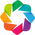

Filtered out 90 entities that appear fewer than 2 times


mRebel model chord diagram saved with frequency filter of 2
Focused chord diagram for 'author' saved with frequency filter of 2


In [3]:
import pandas as pd
import numpy as np
from pathlib import Path
import holoviews as hv
from holoviews import dim, opts
from bokeh.io import save, output_file

# Minimum number of times an entity must appear to be included in visualization
numerical = 2  # Filter threshold - adjust this value as needed

# Set up holoviews
hv.extension('bokeh')

# Create the visualization directory if it doesn't exist
Path("visualizations").mkdir(exist_ok=True)

# Load the data
df = pd.read_csv('triplets_output.csv')

# Clean up the data
df['RELATION'] = df['RELATION'].str.split('  ').str[0]
df = df.drop_duplicates(subset=['HEAD', 'RELATION', 'TAIL'])

# Filter for mrebel model only
mrebel_df = df[df['MODEL'] == 'mrebel']

# Create a chord diagram for the top relationships
# Get top relationship types
top_relations = mrebel_df['TAIL'].value_counts().nlargest(10).index.tolist()
filtered_df = mrebel_df[mrebel_df['TAIL'].isin(top_relations)]

# Get the most frequent entities for a cleaner visualization
entity_counts = {}
for entity in set(filtered_df['HEAD'].tolist() + filtered_df['RELATION'].tolist()):
    head_count = len(filtered_df[filtered_df['HEAD'] == entity])
    relation_count = len(filtered_df[filtered_df['RELATION'] == entity])
    entity_counts[entity] = head_count + relation_count

# Filter entities that appear less than the numerical threshold
filtered_entities = {entity: count for entity, count in entity_counts.items() if count >= numerical}
print(f"Filtered out {len(entity_counts) - len(filtered_entities)} entities that appear fewer than {numerical} times")

# Limit to top entities to prevent overcrowding, but only from filtered set
top_entities = sorted(filtered_entities.items(), key=lambda x: x[1], reverse=True)[:25]
top_entity_names = [e[0] for e in top_entities]

# Filter data to only include top entities
final_df = filtered_df[
    (filtered_df['HEAD'].isin(top_entity_names) | filtered_df['RELATION'].isin(top_entity_names)) & 
    (filtered_df['TAIL'].isin(top_relations))
]

# Create link data for the chord diagram
links = []
for _, row in final_df.iterrows():
    # Format: (source, target, relation_type)
    links.append((row['HEAD'], row['RELATION'], row['TAIL']))

# Check if we have enough links for a meaningful visualization
if len(links) < 2:
    print(f"Warning: Not enough data points remaining after filtering (only {len(links)} links). Try lowering the numerical threshold.")
    
if len(links) > 0:
    # Create the chord diagram
    chord = hv.Chord(links).select(value=lambda x: x > 0)
    chord = chord.opts(
        opts.Chord(
            cmap='Category20', 
            edge_cmap='Category20', 
            edge_color=dim('source').str(),
            labels='index', 
            node_color=dim('index').str(),
            width=900, 
            height=900, 
            title=f'mRebel Model - Relationship Network (Min. {numerical} occurrences)',
            bgcolor='#222222', 
            edge_alpha=0.7, 
            label_text_color='white',
            fontsize={'title': 16},
            label_text_font_size='9pt'
        )
    )

    # Save the chord diagram
    output_file("visualizations/mrebel_relationship_chord.html")
    save(hv.render(chord))
    print(f"mRebel model chord diagram saved with frequency filter of {numerical}")

    # Generate a more detailed chord focusing on a single relationship type
    most_common_relation = mrebel_df['TAIL'].value_counts().index[0]
    focused_df = mrebel_df[mrebel_df['TAIL'] == most_common_relation]

    # Apply the same numerical filter to this visualization
    focused_entity_counts = {}
    for entity in set(focused_df['HEAD'].tolist() + focused_df['RELATION'].tolist()):
        head_count = len(focused_df[focused_df['HEAD'] == entity])
        relation_count = len(focused_df[focused_df['RELATION'] == entity])
        focused_entity_counts[entity] = head_count + relation_count
        
    # Only include entities that meet the threshold
    filtered_focused_entities = [entity for entity, count in focused_entity_counts.items() 
                               if count >= numerical]
    
    # Create links for this focused view (with the filter applied)
    focused_df_filtered = focused_df[
        (focused_df['HEAD'].isin(filtered_focused_entities)) & 
        (focused_df['RELATION'].isin(filtered_focused_entities))
    ]
    
    focused_links = []
    for _, row in focused_df_filtered.iterrows():
        focused_links.append((row['HEAD'], row['RELATION'], 1))  # Weight of 1 for all links

    if len(focused_links) > 0:
        # Create a second chord diagram
        focused_chord = hv.Chord(focused_links).select(value=lambda x: x > 0)
        focused_chord = focused_chord.opts(
            opts.Chord(
                cmap='Spectral', 
                edge_cmap='Spectral', 
                labels='index', 
                node_color=dim('index').str(),
                width=800, 
                height=800, 
                title=f'mRebel Model - "{most_common_relation}" Relationship (Min. {numerical} occurrences)',
                bgcolor='#222222', 
                edge_alpha=0.8, 
                label_text_color='white',
                fontsize={'title': 16},
                label_text_font_size='10pt'
            )
        )

        # Save the focused chord diagram
        output_file(f"visualizations/mrebel_{most_common_relation.replace(' ', '_')}_chord.html")
        save(hv.render(focused_chord))
        print(f"Focused chord diagram for '{most_common_relation}' saved with frequency filter of {numerical}")
    else:
        print(f"Not enough data for focused chord after applying numerical filter of {numerical}")
else:
    print("No chord diagrams were generated due to insufficient data after filtering")